In [10]:
import numpy as np
import os
from typing import List
import re
import pandas as pd
import matplotlib.pyplot as plt 
import mne 
from mne.stats import permutation_cluster_test
import sklearn
import spacy
import random
from fastcoref import spacy_component
nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("fastcoref", last=True)
import syllapy
import scipy.stats as stats

c:\Users\ricky\miniforge3\envs\ds125\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
06/09/2024 16:21:28 - INFO - 	 missing_keys: []
06/09/2024 16:21:28 - INFO - 	 unexpected_keys: []
06/09/2024 16:21:28 - INFO - 	 mismatched_keys: []
06/09/2024 16:21:28 - INFO - 	 error_msgs: []
06/09/2024 16:21:28 - INFO - 	 Model Parameters: 90.5M, Transformer: 82.1M, Coref head: 8.4M


# Preprocessing

In [134]:
mne.set_log_level(verbose=False)

## Basic Cleaning

In [135]:
# define data paths 
root_dir = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Data"

# params
subject = 'sub-001'
ses = 'ses-001'

# file paths
meg_path = '%s/%s/%s/meg/%s_%s_task-compr_meg.ds' % (root_dir, subject, ses, subject, ses)
event_path = '%s/%s/%s/meg/%s_%s_task-compr_events.tsv' % (root_dir, subject, ses, subject, ses)

In [136]:
# load the meg data for this subject and session 
raw = mne.io.read_raw_ctf(meg_path)

In [137]:
# crop just the first 10 minutes 
raw.pick(picks=['mag'])
raw.crop(0, 60*1)
# raw.resample(100)

# load the data into memory
raw.load_data()
raw.filter(0.1, 30, method="iir")

Measurement date,"January 01, 1970 00:00:00 GMT"
Experimenter,Unknown
Participant,
Digitized points,11 points
Good channels,269 Magnetometers
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,1200.00 Hz
Highpass,0.10 Hz
Lowpass,30.00 Hz


In [206]:
df = pd.read_csv(event_path, delimiter='\t')
# subset given events of interest
df_crop = df[df['type'].str.contains('word_onset', na=False)]

# remove silence
df_crop = df_crop.query("value != 'sp'")
df_crop

,onset,duration,sample,type,value
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES
...,...,...,...,...,...
41115,4648.015340,0.548753,5.577619e+06,word_onset_07,HONOURABLE
41123,4648.564093,0.838095,5.578278e+06,word_onset_07,TITLE
41131,4650.220329,0.089796,5.580265e+06,word_onset_07,OF
41134,4650.310125,0.419048,5.580373e+06,word_onset_07,THE


## POS, Syllable, Coref Tagging

Read in first 5 stories for session 1 data

In [207]:
folder_path = r'C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\stimuli'

full_text = ""

pattern = re.compile(r'01_\d\.txt')

for filename in os.listdir(folder_path):
    if pattern.match(filename):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            full_text += file.read().replace("\n", " ")

In [208]:
def has_accented_characters(token):
    for char in token.text:
        if ord(char) > 127:
            return True
    return False

In [209]:
def find_accent(token):
    idx = 0
    for char in token.text:
        if ord(char) > 127:
            return idx
        idx += 1

In [211]:
def pos_tagger(text):
    """
    Does not work one words with more then 1 accent
    """
    doc = nlp(text)
    pos = []
    tokens = []

    for token in doc:
        if token.text.strip() != "" and not token.is_punct:
            if has_accented_characters(token):
                text = token.text[find_accent(token) + 1:]
                if text != "":
                    pos.append(token.pos_)
                    tokens.append(text)
            elif token.text.lower() in ["n't", "'ll", "'ve", "'m", "'d", "'t", "'s", "'re"]:
                temp = tokens[-1] + token.text
                tokens[-1] = temp
            else:
                pos.append(token.pos_)
                tokens.append(token.text)

    return pos, tokens

pos, token_text = pos_tagger(full_text)
df_crop['POS']  = pos
df_crop


06/04/2024 23:15:30 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:15:32 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

,onset,duration,sample,type,value,POS
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE,DET
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES,NOUN
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF,ADP
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK,PROPN
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES,PROPN
...,...,...,...,...,...,...
41115,4648.015340,0.548753,5.577619e+06,word_onset_07,HONOURABLE,ADJ
41123,4648.564093,0.838095,5.578278e+06,word_onset_07,TITLE,NOUN
41131,4650.220329,0.089796,5.580265e+06,word_onset_07,OF,ADP
41134,4650.310125,0.419048,5.580373e+06,word_onset_07,THE,DET


In [194]:
df_crop = df

Debugging code

In [212]:
values = list(df_crop["value"].str.lower())
token_clean = [text.lower() for text in token_text]

max_length = max(len(values), len(token_clean))
values_padded = values + [None] * (max_length - len(values))
token_clean_padded = token_clean + [None] * (max_length - len(token_clean))

df = pd.DataFrame({'values': values_padded, 'token_clean': token_clean_padded})
first_unequal_row = df.loc[df['values'] != df['token_clean']]#.iloc[:50]
first_unequal_row

,values,token_clean
1561,co,co.
1759,horses',horses
1856,client,client--
2172,dr,dr.
2342,i,i.
2872,how,how--
3405,st,st.
4190,mr,mr.
4548,st,st.
4660,st,st.


Manually changed text:
<!-- 01_07 Ln114: "née" -> "E" -->
06_07: Ln20: "St.--" -> ""
<!-- 04_02: Ln47: "métier" -> "mé tier" -->
<!-- 02_06: Ln140: "carrée" -> "carré e" -->
<!-- 03_5: Ln7: "dénouement" -> "dé nouement" -->
10_05: Ln 9: "pâté" -> "paté"

In [213]:
df_crop["syllables"] = df_crop["value"].apply(syllapy.count)
df_crop

,onset,duration,sample,type,value,POS,syllables
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE,DET,1
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES,NOUN,4
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF,ADP,1
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK,PROPN,2
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES,PROPN,2
...,...,...,...,...,...,...,...
41115,4648.015340,0.548753,5.577619e+06,word_onset_07,HONOURABLE,ADJ,4
41123,4648.564093,0.838095,5.578278e+06,word_onset_07,TITLE,NOUN,2
41131,4650.220329,0.089796,5.580265e+06,word_onset_07,OF,ADP,1
41134,4650.310125,0.419048,5.580373e+06,word_onset_07,THE,DET,1


In [197]:
def get_text_from_indices(text, clusters):
    spans = []
    for cluster in clusters:
        span = [text[start:end] for start, end in cluster]
        spans.append(span)
    return spans

In [198]:
# nlp.add_pipe("fastcoref")
doc = nlp(full_text)


06/04/2024 23:13:45 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:13:48 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [199]:
clusters = doc._.coref_clusters
coref_words = get_text_from_indices(full_text, clusters)

In [200]:
for group in coref_words:
    print(group)

['SHERLOCK HOLMES', 'Sherlock Holmes', 'him', 'his', 'he', 'his', 'He', 'he', 'himself', 'He', 'his', 'his', 'him', 'Holmes', 'the man who first finds himself master of his own establishment', 'Holmes, who loathed every form of society with his whole Bohemian soul', 'his', 'his', 'his', 'He', 'his', 'his', 'his', 'his', 'he', 'his', 'my former friend and companion', 'Holmes', 'he', 'his', 'His', 'his', 'He', 'his', 'his', 'his', 'him', 'his', 'his', 'He', 'He', 'his', 'His', 'he', 'he', 'his', 'he', 'his', 'he', 'I', 'I', 'My dear Holmes', 'you', 'you', 'your', 'you', 'you', 'your', 'he', 'his', 'you', 'your', 'your', 'you', 'your', 'he', 'himself', 'your', 'Holmes', 'you', 'Holmes', 'He', 'his', 'my boy', 'you', 'he', 'Holmes', 'he', 'he', 'Watson', 'Holmes', 'Doctor', 'you', 'your', 'Doctor', 'your', 'Holmes', 'he', 'He', 'Holmes', 'my', 'me', 'my', 'I', 'me', 'I', 'this gentleman, your friend', 'I', 'I', 'Holmes', 'he', 'this gentleman', 'I', 'Holmes', 'I', 'Holmes', 'I', 'Holmes', 

In [201]:
def get_reduced_tokens(spans):
    reduced_tokens = []
    for span in spans:
        pnoun = False
        reduced_token = ""
        nouns = []
        for token in span:
            if token.pos_ in ['PROPN', 'PRON', 'NOUN']:
                if token.pos_ == "PROPN":
                    pnoun = True
                    reduced_token = token
                elif not pnoun:
                    nouns.append(token)
        if pnoun:
            reduced_tokens.append(reduced_token)
        elif len(nouns) > 0:
            reduced_tokens.append(random.choice(nouns))
    return reduced_tokens

In [202]:
def get_head(reduced_spans):
    pnoun = False
    head_token = {}
    for token in reduced_spans:
        if token.pos_ in ['PROPN', 'PRON', 'NOUN']:
                if token.pos_ == "PROPN":
                    pnoun = True
                    if token.text not in head_token:
                        head_token[token.text] = 1
                    else:
                        head_token[token.text] += 1
                elif token.pos_ == "NOUN" and not pnoun:
                    if token.text not in head_token:
                        head_token[token.text] = 1
                    else:
                        head_token[token.text] += 1
    if not head_token:
        return ""
    return max(head_token, key=head_token.get)

In [203]:
def coref_tagger(text):
    """
    Does not work one words with more then 1 accent
    """
    doc = nlp(text)
    resolved = []

    clusters = doc._.coref_clusters

    cluster_dict = {}

    for cluster in clusters:
        spans = [doc.char_span(span[0],span[1]) for span in cluster]
        reduced_tokens = get_reduced_tokens(spans)
        cluster_head = get_head(reduced_tokens)
        for token in reduced_tokens:
            cluster_dict[token] = cluster_head

    for token in doc:
        if token.text.strip() != "" and not token.is_punct and \
            token.text.lower() not in ["n't", "'ll", "'ve", "'m", "'d", "'t", "'s", "'re"]:
            if has_accented_characters(token):
                if ord(token.text[-1]) > 127:
                    continue
            if token in cluster_dict and cluster_dict[token] != "":
                resolved.append(cluster_dict[token])
            else:
                resolved.append(None)

    return resolved

coref = coref_tagger(full_text)
df_crop['coref']  = coref
df_crop

06/04/2024 23:13:58 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:14:00 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Length of values (8622) does not match length of index (42208)

In [214]:
def coref_tagger(text: str) -> list:
    """
    Processes the given text to resolve coreferences. Note: This function 
    does not work on words with more than one accent.

    Parameters:
    text (str): The input text to be processed.

    Returns:
    list: A list of resolved tokens or None for unresolved tokens.
    """
    doc = nlp(text)
    resolved = []
    cluster_dict = {}

    # Extract coreference clusters
    clusters = doc._.coref_clusters
    for cluster in clusters:
        spans = [doc.char_span(span[0], span[1]) for span in cluster]
        reduced_tokens = get_reduced_tokens(spans)
        cluster_head = get_head(reduced_tokens)
        for token in reduced_tokens:
            cluster_dict[token] = cluster_head

    for token in doc:
        if token.text.strip() and not token.is_punct and \
                token.text.lower() not in ["n't", "'ll", "'ve", "'m", "'d", "'t", "'s", "'re"]:
            if has_accented_characters(token):
                if ord(token.text[-1]) > 127:
                    continue
            resolved.append(cluster_dict.get(token, None))

    return resolved

coref = coref_tagger(full_text)
df_crop['coref']  = coref
df_crop

06/04/2024 23:15:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:16:01 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

,onset,duration,sample,type,value,POS,syllables,coref
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE,DET,1,None
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES,NOUN,4,None
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF,ADP,1,None
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK,PROPN,2,None
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES,PROPN,2,Holmes
...,...,...,...,...,...,...,...,...
41115,4648.015340,0.548753,5.577619e+06,word_onset_07,HONOURABLE,ADJ,4,None
41123,4648.564093,0.838095,5.578278e+06,word_onset_07,TITLE,NOUN,2,None
41131,4650.220329,0.089796,5.580265e+06,word_onset_07,OF,ADP,1,None
41134,4650.310125,0.419048,5.580373e+06,word_onset_07,THE,DET,1,None


In [205]:
df_crop

,onset,duration,sample,type,value,syllables
0,37.774454,NaN,4.533034e+04,wav_onset,10,0
1,37.786092,1.077551,4.534431e+04,word_onset_01,sp,1
2,37.786092,1.077551,4.534431e+04,phoneme_onset_01,sp,1
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE,1
4,38.863643,0.059864,4.663737e+04,phoneme_onset_01,DH,1
...,...,...,...,...,...,...
42203,4910.000000,10.000000,5.892001e+06,trial,NaN,0
42204,4910.178333,NaN,5.892215e+06,UPPT002,2,0
42205,4910.178652,NaN,5.892215e+06,Response,NaN,0
42206,4920.000000,10.000000,5.904001e+06,trial,NaN,0


In [ ]:
df_crop.iloc[:10, :]

,onset,duration,sample,type,value,POS,syllables,coref
3,38.863643,0.129705,46637.372038,word_onset_01,THE,DET,1,None
6,38.993349,0.678458,46793.018296,word_onset_01,ADVENTURES,NOUN,4,None
15,39.671807,0.089796,47607.167956,word_onset_01,OF,ADP,1,None
18,39.761603,0.488889,47714.923058,word_onset_01,SHERLOCK,PROPN,2,None
24,40.250491,0.698413,48301.589725,word_onset_01,HOLMES,PROPN,2,Holmes
31,41.687226,0.149660,50025.671358,word_onset_01,A,DET,1,None
33,41.836886,0.698413,50205.263194,word_onset_01,SCANDAL,PROPN,2,None
43,42.714891,0.229478,51258.868636,word_onset_01,IN,ADP,1,None
46,42.944369,0.558730,51534.242786,word_onset_01,BOHEMIA,PROPN,3,None
56,46.047317,0.169615,55257.780201,word_onset_01,TO,ADP,1,None


In [ ]:
df_crop[df_crop["value"] == "I"]

,onset,duration,sample,type,value,POS,syllables,coref
97,50.826455,0.209524,6.099275e+04,word_onset_01,I,PRON,1,Watson
375,73.355253,0.129705,8.802730e+04,word_onset_01,I,PRON,1,Watson
1102,128.849131,0.039909,1.546200e+05,word_onset_01,I,PRON,1,Watson
1845,184.831897,0.149660,2.217993e+05,word_onset_01,I,PRON,1,Watson
2162,207.989267,0.229478,2.495881e+05,word_onset_01,I,PRON,1,Watson
2211,211.571126,0.139683,2.538864e+05,word_onset_01,I,PRON,1,Watson
2320,220.450945,0.129705,2.645421e+05,word_onset_01,I,PRON,1,Watson
2363,223.703553,0.099773,2.684453e+05,word_onset_01,I,PRON,1,Watson
2436,229.430537,0.089796,2.753176e+05,word_onset_01,I,PRON,1,Watson
...,...,...,...,...,...,...,...,...


In [ ]:
cluster = clusters[0]
spans = [doc.char_span(span[0],span[1]) for span in cluster]
reduced_spans = get_reduced_tokens(spans)
get_head(reduced_spans)

In [ ]:
df_crop[df_crop["coref"] == "Holmes"]

## Create Epochs

In [7]:
word_samples = np.array(df_crop['onset'] * raw.info['sfreq'], dtype='int')
n_words = len(word_samples)

# put the event times into a matrix shape that mne python expects
word_events = np.zeros([n_words, 3], dtype='int')
word_events[:, 0] = word_samples

In [8]:
# make epochs of time around each word event 
epochs = mne.Epochs(raw, word_events, tmin=-2.0, tmax=2.0, baseline=(-2.0, 2.0), preload=False, metadata=df_crop, decim=12)

In [9]:
epochs.metadata

,onset,duration,sample,type,value
0,17.350018,0.079819,2.082102e+04,word_onset_01,THE
1,17.429837,0.578685,2.091680e+04,word_onset_01,ADVENTURE
2,18.108295,0.099773,2.173095e+04,word_onset_01,OF
3,18.208068,0.079819,2.185068e+04,word_onset_01,THE
4,18.287886,0.488889,2.194646e+04,word_onset_01,SPECKLED
...,...,...,...,...,...
7875,4846.583823,0.409070,5.815902e+06,word_onset_06,HOURS
7876,4846.992893,0.079819,5.816392e+06,word_onset_06,TO
7877,4847.072712,0.498866,5.816488e+06,word_onset_06,SOMETHING
7878,4847.571578,0.269388,5.817087e+06,word_onset_06,MORE


In [ ]:
10e-4

In [12]:
directory = r'C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\sub_003\ses_08'
if not os.path.exists(directory):
    os.makedirs(directory)

epochs.save(os.path.join(directory, 'epochs.fif'))

C:\Users\ricky\AppData\Local\Temp\ipykernel_36032\1865046542.py:5: RuntimeWarning: This filename (C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\sub_003\ses_08\epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(os.path.join(directory, 'epochs.fif'))


FileExistsError: Destination file exists. Please use option "overwrite=True" to force overwriting.

In [13]:
epochs = mne.read_epochs(os.path.join(directory, 'epochs.fif'))

C:\Users\ricky\AppData\Local\Temp\ipykernel_36032\1647091934.py:1: RuntimeWarning: This filename (C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\sub_003\ses_08\epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(os.path.join(directory, 'epochs.fif'))


In [14]:
epochs.metadata

,onset,duration,sample,type,value
0,17.350018,0.079819,2.082102e+04,word_onset_01,THE
1,17.429837,0.578685,2.091680e+04,word_onset_01,ADVENTURE
2,18.108295,0.099773,2.173095e+04,word_onset_01,OF
3,18.208068,0.079819,2.185068e+04,word_onset_01,THE
4,18.287886,0.488889,2.194646e+04,word_onset_01,SPECKLED
...,...,...,...,...,...
7875,4846.583823,0.409070,5.815902e+06,word_onset_06,HOURS
7876,4846.992893,0.079819,5.816392e+06,word_onset_06,TO
7877,4847.072712,0.498866,5.816488e+06,word_onset_06,SOMETHING
7878,4847.571578,0.269388,5.817087e+06,word_onset_06,MORE


# Analysis 1

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
noun_epochs = epochs["POS == 'PROPN' or POS == 'PRON' or POS == 'NOUN'"]
noun_epochs.metadata

In [ ]:
np_nouns = noun_epochs.get_data()
y = noun_epochs.metadata[["POS"]]

In [ ]:
np_nouns.shape

In [ ]:
enc = OneHotEncoder()
enc_y = enc.fit_transform(X=y)
label_df = pd.DataFrame(enc_y.toarray(), columns=enc.categories_)

In [ ]:
cv_pipeline = make_pipeline(StandardScaler(), LogisticRegressionCV(
    cv=5, scoring="roc_auc", random_state= 125, max_iter=10000, solver="lbfgs"))

In [ ]:
fit_pipeline = make_pipeline(StandardScaler(), LogisticRegression(
     random_state= 125, max_iter=10000, solver="lbfgs"))

In [ ]:
#Toy example
X = np_nouns[:, :, 1]
cv_pipeline.fit(X, y)

## Optimize Hyperparam

In [ ]:
df_scores = pd.DataFrame()
df_params = pd.DataFrame()
for column in label_df.columns:
    column = column[0]
    y = label_df[column].to_numpy().ravel()
    auc_score = []
    hyper_param = []
    for i in range(np_nouns.shape[2]):
        X = np_nouns[:, :, i]
        cv_pipeline.fit(X, y)
        hyper_param.append(cv_pipeline[-1].C_[0])
        skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)
        scores = np.zeros(5)
        for j, (train_index, test_index) in enumerate(skf.split(X, y)):
            X_train = X[train_index]
            y_train = y[train_index]
            X_test = X[test_index]
            y_test = y[test_index]
            fit_pipeline[-1].set_params(C=hyper_param[i])
            fit_pipeline.fit(X_train, y_train)
            score = roc_auc_score(y_test, fit_pipeline.predict_proba(X_test)[:, 1])
            scores[j] = score
        auc_score.append(scores.mean())
    df_scores[column] = auc_score
    df_params[column] = hyper_param
    

In [ ]:
df_scores.to_csv(r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\df_scores.csv")
df_params.to_csv(r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\df_params.csv")

In [113]:
df_scores = pd.read_csv(r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\df_scores.csv", index_col=0)

In [114]:
df_scores

,NOUN,PRON,PROPN
0,0.491148,0.483586,0.492302
1,0.508277,0.511487,0.502924
2,0.466691,0.516350,0.516094
3,0.506915,0.525986,0.539116
4,0.504429,0.497699,0.515358
5,0.515395,0.500005,0.526783
6,0.517301,0.500716,0.501081
7,0.492041,0.510173,0.506912
8,0.520170,0.480491,0.518527
...,...,...,...


In [116]:
title = df_params.columns[0]

NameError: name 'df_params' is not defined

<Axes: >

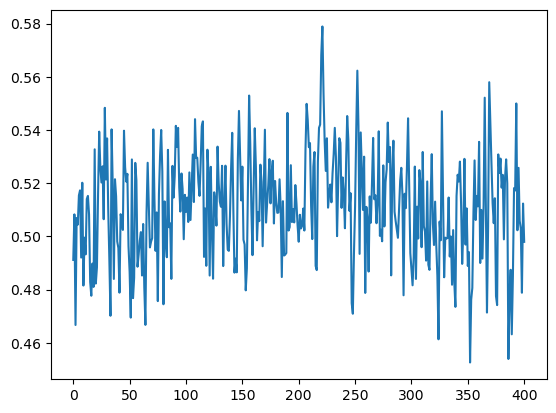

In [115]:
df_scores["NOUN"].plot()

<Axes: >

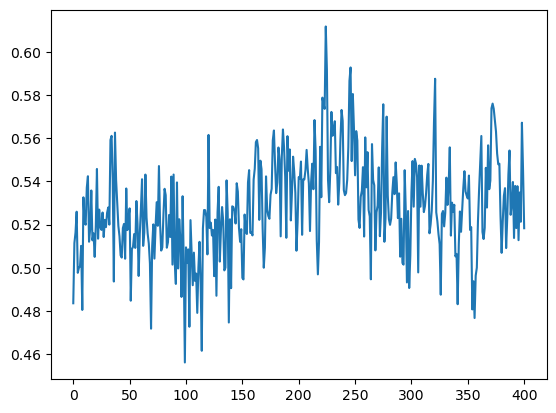

In [117]:
df_scores["PRON"].plot()

<Axes: >

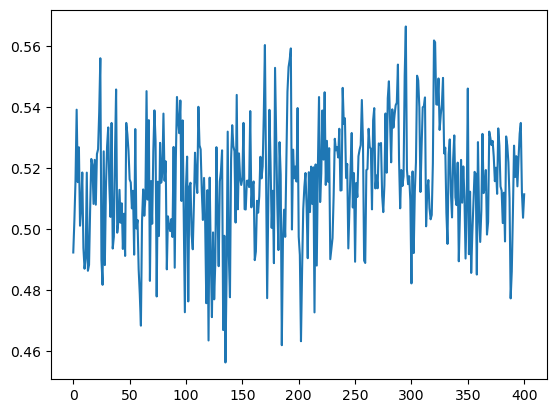

In [118]:
df_scores["PROPN"].plot()

In [119]:
df_params["NOUN"].plot(logy=True)

NameError: name 'df_params' is not defined

In [ ]:
df_params["NOUN"].apply(np.log).mean()

## Full Data

## Permutation Test

In [ ]:
def run_permutation_test(column_name):
    condition1_indices = np.where(label_df[column_name].values == 1)[0]
    condition2_indices = np.where(label_df[column_name].values == 0)[0]

    condition1_data = epochs[condition1_indices].get_data()
    condition2_data = epochs[condition2_indices].get_data()

    X = [condition1_data, condition2_data]

    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(X, 
                                                                     n_permutations=1000,
                                                                     threshold=1.96,
                                                                     tail=0,
                                                                     n_jobs=-1)
    return T_obs, clusters, cluster_p_values, H0

# Running the tests for each column
columns = ["PRON", "PROPN", "NOUN"]
results = {}
for column in columns:
    T_obs, clusters, cluster_p_values, H0 = run_permutation_test(column)
    results[column] = {
        "T_obs": T_obs,
        "clusters": clusters,
        "cluster_p_values": cluster_p_values,
        "H0": H0
    }


In [ ]:
np.where(label_df["NOUN"].values)[0]

In [ ]:
label_df

# Analysis 2

When selecting nouns is it across whole story?

In [ ]:
df_crop

In [189]:
mask = df_crop["POS"].isin(["NOUN", "PROPN"])
counts = df_crop[mask]["value"].value_counts()

KeyError: 'POS'

In [ ]:
from IPython.display import display
pd.set_option('display.max_rows', None)

In [ ]:
pd.reset_option('display.max_rows')

In [223]:
def read_meg(meg_path: str, event_path: str):
    """
    Read and preprocess MEG data from the given path, clean and filter the data,
    and return it along with the event DataFrame.

    Parameters:
    meg_path (str): The file path to the MEG data.
    event_path (str): The file path to the event data.

    Returns:
    tuple: A tuple containing the preprocessed raw MEG data and the cleaned event DataFrame.
    """
    raw = mne.io.read_raw_ctf(meg_path, preload=False)
    # raw.pick(picks=['mag'])
    # raw.resample(100)
    # raw.load_data()
    # raw.filter(0.1, 30, method='iir')

    df = pd.read_csv(event_path, delimiter='\t')
    df_crop = df[df['type'].str.contains('word_onset', na=False)]
    df_crop = df_crop.query("value != 'sp'")

    return raw, df_crop


def session_text(root_dir: str, session: str) -> str:
    """
    Concatenate text from files matching a specific session pattern in the given directory.

    Parameters:
    root_dir (str): The root directory containing the stimuli files.
    session (str): The session identifier to match files.

    Returns:
    str: The concatenated text from all matching files.
    """
    full_text = ""
    pattern = re.compile(f'{session}_\\d\\.txt')
    stimuli_dir = os.path.join(root_dir, "stimuli")

    for filename in os.listdir(stimuli_dir):
        if pattern.match(filename):
            file_path = os.path.join(stimuli_dir, filename)
            with open(file_path, 'r') as file:
                full_text += file.read().replace("\n", " ")

    return full_text


def story_text(root_dir: str) -> str:
    """
    Read and concatenate full story from the specified directory.

    Parameters:
    root_dir (str): The root directory containing the text files.

    Returns:
    str: The concatenated text from all the text files in the directory.
    """
    full_text = ""
    stimuli_dir = os.path.join(root_dir, "stimuli")
    
    for filename in os.listdir(stimuli_dir):
        if filename.endswith(".txt"):
            file_path = os.path.join(stimuli_dir, filename)
            with open(file_path, 'r') as file:
                full_text += file.read().replace("\n", " ")

    return full_text


def has_accented_characters(token) -> bool:
    """
    Checks if the given token has any accented characters.

    Parameters:
    token (spacy.tokens.Token): The token to be checked.

    Returns:
    bool: True if the token has accented characters, False otherwise.
    """
    return any(ord(char) > 127 for char in token.text)


def find_accent(token) -> int:
    """
    Finds the index of the first accented character in the token.

    Parameters:
    token (spacy.tokens.Token): The token to be checked.

    Returns:
    int: The index of the first accented character, or -1 if none are found.
    """
    for idx, char in enumerate(token.text):
        if ord(char) > 127:
            return idx
    return -1


def pos_tagger(text: str) -> tuple:
    """
    Tags parts of speech in the given text. Note: This function does not work 
    on words with more than one accent.

    Parameters:
    text (str): The input text to be processed.

    Returns:
    tuple: A tuple containing two lists - parts of speech tags and corresponding tokens.
    """
    doc = nlp(text)
    pos = []
    tokens = []

    for token in doc:
        if token.text.strip() and not token.is_punct:
            if has_accented_characters(token):
                text = token.text[find_accent(token) + 1:]
                if text:
                    pos.append(token.pos_)
                    tokens.append(text)
            elif token.text.lower() in ["n't", "'ll", "'ve", "'m", "'d", "'t", "'s", "'re"]:
                tokens[-1] += token.text
            else:
                pos.append(token.pos_)
                tokens.append(token.text)

    return pos, tokens


def get_reduced_tokens(spans: List[spacy.tokens.Span]) -> List[spacy.tokens.Token]:
    """
    Reduce tokens in each span to a single representative token based on part of speech tags.

    Parameters:
    spans (List[spacy.tokens.Span]): A list of spacy token spans.

    Returns:
    List[spacy.tokens.Token]: A list of reduced tokens.
    """
    reduced_tokens = []

    for span in spans:
        pnoun = False
        reduced_token = None
        nouns = []

        for token in span:
            if token.pos_ in ['PROPN', 'PRON', 'NOUN']:
                if token.pos_ == "PROPN":
                    pnoun = True
                    reduced_token = token
                elif not pnoun:
                    nouns.append(token)

        if pnoun:
            reduced_tokens.append(reduced_token)
        elif nouns:
            reduced_tokens.append(random.choice(nouns))

    return reduced_tokens


def get_head(reduced_spans) -> str:
    """
    Determine the head token from the given spans based on their part of speech tags.

    Parameters:
    reduced_spans (list): A list of spacy tokens.

    Returns:
    str: The head token with the highest frequency, or an empty string if no head token is found.
    """
    pnoun = False
    head_token = {}

    for token in reduced_spans:
        if token.pos_ in ['PROPN', 'PRON', 'NOUN'] and token.text != "I.":
            if token.pos_ == "PROPN":
                pnoun = True
                head_token[token.text] = head_token.get(token.text, 0) + 1
            elif token.pos_ == "NOUN" and not pnoun:
                head_token[token.text] = head_token.get(token.text, 0) + 1

    if not head_token:
        return ""
    
    return max(head_token, key=head_token.get)


def coref_tagger(text: str) -> list:
    """
    Processes the given text to resolve coreferences. Note: This function 
    does not work on words with more than one accent.

    Parameters:
    text (str): The input text to be processed.

    Returns:
    list: A list of resolved tokens or None for unresolved tokens.
    """
    doc = nlp(text)
    resolved = []
    cluster_dict = {}

    # Extract coreference clusters
    clusters = doc._.coref_clusters
    for cluster in clusters:
        spans = [doc.char_span(span[0], span[1]) for span in cluster]
        reduced_tokens = get_reduced_tokens(spans)
        cluster_head = get_head(reduced_tokens)
        for token in reduced_tokens:
            cluster_dict[token] = cluster_head

    for token in doc:
        if token.text.strip() and not token.is_punct and \
                token.text.lower() not in ["n't", "'ll", "'ve", "'m", "'d", "'t", "'s", "'re"]:
            if has_accented_characters(token):
                if ord(token.text[-1]) > 127:
                    continue
            if token in cluster_dict and cluster_dict[token] != "":
                resolved.append(cluster_dict[token])
            else:
                resolved.append(None)

    return resolved


def create_epochs(df: pd.DataFrame, raw: mne.io.Raw) -> mne.Epochs:
    """
    Create epochs from MEG data using event information from a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing event information with 'onset' column.
    raw (mne.io.Raw): The raw MEG data.

    Returns:
    mne.Epochs: The created epochs.
    """
    word_samples = np.array(df['onset'] * raw.info['sfreq'], dtype='int')
    n_words = len(word_samples)

    word_events = np.zeros((n_words, 3), dtype='int')
    word_events[:, 0] = word_samples

    epochs = mne.Epochs(raw, word_events, tmin=-2.0, tmax=2.0, baseline=(-2.0, 2.0), preload=False, metadata=df)
    return epochs

In [224]:
root_dir = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Data"
save_dir = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_2"
patients = ["01", "02", "03"]
pat_id = "01"


all_data = []
all_labels = []
ses_ids = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10"]

for ses_id in ses_ids:
    meg_path = f'{root_dir}/sub-0{pat_id}/ses-0{ses_id}/meg/sub-0{pat_id}_ses-0{ses_id}_task-compr_meg.ds'
    event_path = f'{root_dir}/sub-0{pat_id}/ses-0{ses_id}/meg/sub-0{pat_id}_ses-0{ses_id}_task-compr_events.tsv'

    raw, df = read_meg(meg_path, event_path)
    text = session_text(root_dir, ses_id)

    print(f"Processing session {ses_id} for patient {pat_id}")
    df['POS'], _ = pos_tagger(text)
    df["syllables"] = df["value"].apply(syllapy.count)
    df['coref'] = coref_tagger(text)

    # epochs = create_epochs(df, raw)
    # noun_epochs = epochs["POS == 'PROPN' or POS == 'PRON' or POS == 'NOUN'"]
    # data = noun_epochs.get_data()
    # all_data.append(data)
    # metadata = noun_epochs.metadata
    all_labels.append(df)

# X = np.concatenate(all_data, axis=0)
metadata = pd.concat(all_labels, axis=0)

Processing session 01 for patient 01


06/04/2024 23:19:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:19:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:19:23 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:19:24 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 02 for patient 01


06/04/2024 23:19:34 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:19:36 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:19:49 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:19:52 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 03 for patient 01


06/04/2024 23:20:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:20:11 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:12 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 04 for patient 01


06/04/2024 23:20:20 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:22 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:20:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 05 for patient 01


06/04/2024 23:20:44 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:46 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:20:53 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:20:54 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 06 for patient 01


06/04/2024 23:21:02 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:21:04 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:21:14 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:21:16 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 07 for patient 01


06/04/2024 23:21:26 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:21:28 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:21:36 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:21:38 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 08 for patient 01


06/04/2024 23:21:46 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:21:48 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:21:59 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:22:01 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 09 for patient 01


06/04/2024 23:22:12 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:22:13 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:22:22 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:22:23 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

Processing session 10 for patient 01


06/04/2024 23:22:32 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:22:34 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

06/04/2024 23:22:42 - INFO - 	 Tokenize 1 inputs...


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

06/04/2024 23:22:44 - INFO - 	 ***** Running Inference on 1 texts *****


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

In [15]:
mask = metadata["POS"].isin(["PRON"])
pos_counts = metadata[mask]["value"].value_counts()

In [16]:
masked = metadata[mask]
it_mask = masked[masked["value"] == "IT"]
it_mask[pd.notnull(it_mask["coref"])]["coref"].value_counts()

coref
slung       23
case        19
paper       16
hat         14
diamond     13
            ..
Coventry     1
box          1
Fordham      1
verdict      1
ceremony     1
Name: count, Length: 238, dtype: int64

In [17]:
pos_counts[pos_counts > 30]

value
I            2300
IT           1368
HE           1187
YOU          1154
HIS           959
MY            776
WHICH         629
ME            486
WE            452
HIM           342
HER           334
SHE           318
THERE         302
YOUR          301
THAT          301
WHAT          297
WHO           210
OUR           164
THEY          161
US            156
ALL           117
THIS          116
THEM          113
NOTHING        89
THEIR          77
ITS            71
MYSELF         61
HIMSELF        58
SOMETHING      54
ANYTHING       42
YOURSELF       34
WHOM           32
Name: count, dtype: int64

In [187]:
mask = metadata["POS"].isin(["PRON"])
coref_counts = metadata[mask]["coref"].value_counts()

NameError: name 'metadata' is not defined

In [20]:
coref_counts[coref_counts > 80]

coref
Holmes        2194
Watson        1297
Doctor         475
man            377
McCarthy       286
Clair          275
mine           259
Doran          220
Turner         118
Sutherland     109
bit            108
Simon          106
Ryder          101
Frank           97
Hatherley       94
Stoner          94
Adler           92
Wilson          90
Ferguson        85
Angel           85
Lestrade        84
Name: count, dtype: int64

In [26]:
top_characters = coref_counts.head(21).index.tolist()
top_characters.remove("man")
top_characters.remove("bit")
top_characters.remove("mine")
top_characters


['Holmes',
 'Watson',
 'Doctor',
 'McCarthy',
 'Clair',
 'Doran',
 'Turner',
 'Sutherland',
 'Simon',
 'Ryder',
 'Frank',
 'Hatherley',
 'Stoner',
 'Adler',
 'Wilson',
 'Ferguson',
 'Angel',
 'Lestrade']

In [39]:
mask = metadata["POS"].isin(["PRON"])
mask2 = metadata["coref"].isin(top_characters)
valid_pos = metadata[mask & mask2]["value"].value_counts()
pronouns = valid_pos[valid_pos > 100].index.tolist()
pronouns

['I', 'YOU', 'HE', 'MY', 'HIS', 'ME', 'YOUR', 'SHE', 'HIM', 'HER']

In [204]:
pd.set_option('display.max_rows', 40)

In [102]:
masked_metadata = metadata[mask]
filtered_metadata = masked_metadata[pd.notnull(masked_metadata["coref"])]
filtered_metadata[filtered_metadata["value"] == "I"]

,onset,duration,sample,type,value,POS,syllables,coref
97,50.826455,0.209524,6.099275e+04,word_onset_01,I,PRON,1,Watson
375,73.355253,0.129705,8.802730e+04,word_onset_01,I,PRON,1,Watson
1102,128.849131,0.039909,1.546200e+05,word_onset_01,I,PRON,1,Watson
1845,184.831897,0.149660,2.217993e+05,word_onset_01,I,PRON,1,Watson
2162,207.989267,0.229478,2.495881e+05,word_onset_01,I,PRON,1,Watson
...,...,...,...,...,...,...,...,...
38364,3696.632066,0.129705,4.435959e+06,word_onset_06,I,PRON,1,Doran
38565,3709.502815,0.129705,4.451404e+06,word_onset_06,I,PRON,1,Doran
38610,3713.084674,0.179592,4.455703e+06,word_onset_06,I,PRON,1,Doran
38669,3717.823903,0.069841,4.461390e+06,word_onset_06,I,PRON,1,Doran


In [46]:
full_story = story_text(root_dir)
x = len(full_story.split(" "))

In [130]:
with open(r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\full_story.txt", "w") as file:
    file.write(full_story)

In [126]:
words = full_story.split(" ")
for i, word in enumerate(words):
    if word == "I.":
        print(i)

10930
12049
12148
12238
18270
38212
43919
44303
46901
59777
62755
64606
68575
73574


In [129]:
words[10920:10940]

['been',
 'very',
 'handy.',
 '',
 '"\'Tell',
 'me',
 'all',
 'about',
 "it,'",
 'said',
 'I.',
 '',
 '"\'Well,\'',
 'said',
 'he,',
 'showing',
 'me',
 'the',
 'advertisement,',
 "'you"]

In [45]:
characters_with_2_syllables = [char for char in top_characters if syllapy.count(char) == 2]

characters_with_2_syllables

['Holmes',
 'Watson',
 'Doctor',
 'McCarthy',
 'Doran',
 'Turner',
 'Simon',
 'Ryder',
 'Stoner',
 'Adler',
 'Wilson',
 'Angel',
 'Lestrade']

In [206]:
x * 0.001

87.229

In [7]:
epochs = mne.read_epochs(f"{root_dir}/sub_001/ses_001/clean-epo.fif", preload=False)
df = epochs.metadata

# df['POS'], token_text = pos_tagger(full_text)

Reading C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\sub_001\ses_001\clean-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Reading C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\sub_001\ses_001\clean-epo-1.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Adding metadata with 5 columns
8622 matching events found
No baseline correction applied
0 projection items activated


In [8]:
df

,onset,duration,sample,type,value
0,38.863643,0.129705,4.663737e+04,word_onset_01,THE
1,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES
2,39.671807,0.089796,4.760717e+04,word_onset_01,OF
3,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK
4,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES
...,...,...,...,...,...
8617,4648.015340,0.548753,5.577619e+06,word_onset_07,HONOURABLE
8618,4648.564093,0.838095,5.578278e+06,word_onset_07,TITLE
8619,4650.220329,0.089796,5.580265e+06,word_onset_07,OF
8620,4650.310125,0.419048,5.580373e+06,word_onset_07,THE


# Permutation Cluster Tests

In [84]:
from mne.stats import permutation_cluster_1samp_test

In [85]:
1 - 0.5 /2

0.75

In [86]:
def get_threshold(alpha, df):
    t_value_two_tailed = stats.t.ppf(1 - alpha / 2, df)
    return t_value_two_tailed

Analysis 1

In [87]:
def extract_column_to_numpy(folder_path, column_name):
    numpy_arrays = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            if column_name in df.columns:
                numpy_array = df[column_name].values
                numpy_arrays.append(numpy_array)
    
    return numpy_arrays

In [277]:
path = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_1A"

# Running the tests for each column
columns = ["PRON", "PROPN", "NOUN"]
results = {}
average_df = pd.DataFrame()
se_df = pd.DataFrame()
for column in columns:
    X = extract_column_to_numpy(path, column)
    average_df[column] = np.mean(X, axis=0)
    se_df[column] = stats.sem(X, axis=0)
    X_adj = [x - 0.5 for x in X]
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='indices')
    results[column] = {
        "T_obs": T_obs,
        "clusters": clusters,
        "cluster_p_values": cluster_p_values,
        "H0": H0
    }


stat_fun(H1): min=-1.4138080772307815 max=41.76125790390751
Running initial clustering …
Found 11 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=0.9309167812791206 max=14.70760928191568
Running initial clustering …
Found 44 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

stat_fun(H1): min=-2.7187857888288582 max=40.288392442912674
Running initial clustering …
Found 17 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [89]:
get_threshold(0.001, 15)

4.0727651959038464

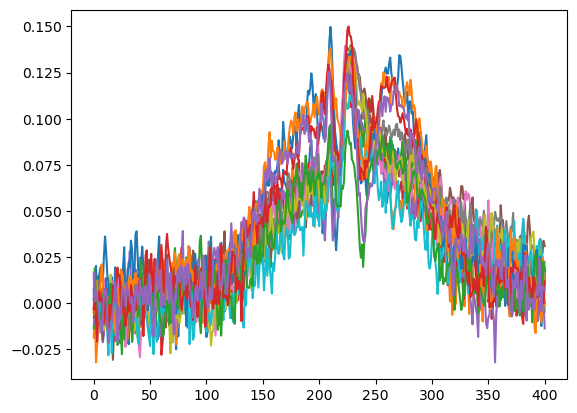

In [90]:
plt.plot(np.array(X_adj).T)

In [278]:
results["PROPN"]["cluster_p_values"]

array([7.740e-02, 6.230e-02, 8.010e-02, 2.940e-02, 6.700e-03, 6.600e-03,
       4.780e-02, 6.760e-02, 5.140e-02, 1.095e-01, 2.600e-03, 3.600e-03,
       5.270e-02, 1.200e-02, 3.600e-03, 2.090e-02, 8.320e-02, 6.010e-02,
       7.580e-02, 4.100e-03, 9.870e-02, 2.100e-02, 5.600e-02, 3.600e-03,
       3.180e-02, 1.200e-02, 5.550e-02, 6.000e-03, 9.100e-03, 7.010e-02,
       9.400e-02, 3.200e-02, 4.410e-02, 1.130e-02, 8.400e-02, 3.600e-03,
       1.000e-04, 3.010e-02, 8.770e-02, 2.100e-03, 4.050e-02, 4.560e-02,
       5.610e-02, 6.000e-03])

In [284]:
results["PROPN"]["clusters"][20:]

[(array([143]),),
 (array([145, 146]),),
 (array([151]),),
 (array([155, 156, 157, 158, 159]),),
 (array([163]),),
 (array([168, 169]),),
 (array([177]),),
 (array([179, 180, 181]),),
 (array([187, 188]),),
 (array([195]),),
 (array([198]),),
 (array([204]),),
 (array([210]),),
 (array([213, 214]),),
 (array([216]),),
 (array([220, 221, 222, 223]),),
 (array([226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
         239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
         252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
         265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
         278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
         291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303,
         304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316,
         317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329,
         330, 331, 332, 333, 334, 335, 336, 337, 338, 3

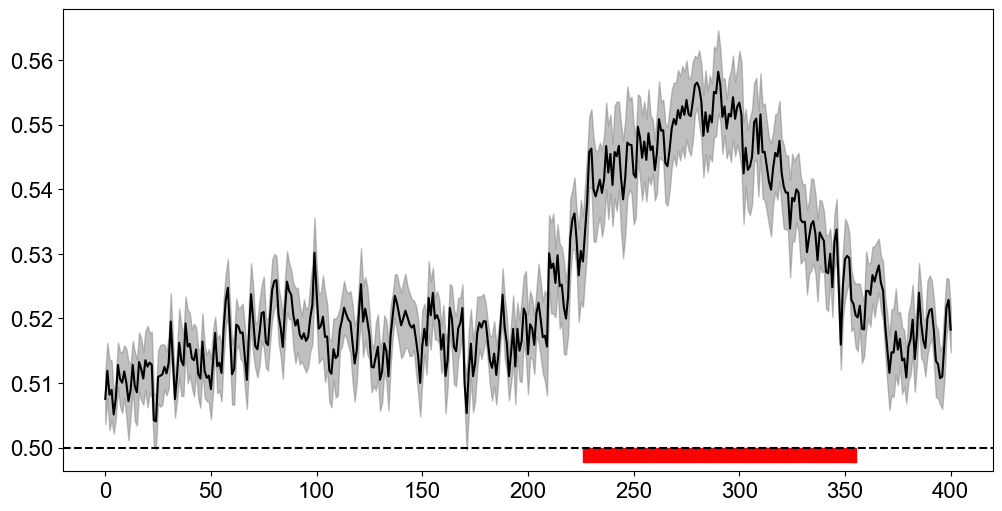

In [283]:
import matplotlib.pyplot as plt

# Assuming average_df and se_df are already defined and contain the same time index

# Extract the time and parameter estimate
time = average_df.index
estimate = average_df["PROPN"]  # Adjust the column name as needed
se = se_df["PROPN"]  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.5, label="Error band")

# Add a horizontal black dashed line at y=0.5 if needed
ax.axhline(y=0.5, color='black', linestyle='--')

for i, cluster in enumerate(results["PROPN"]["clusters"]):
    if results["PROPN"]["cluster_p_values"][i] < 0.001:
        start, end = time[cluster[0][0]], time[cluster[0][-1]]
        ax.axvspan(start, end, color='red', ymin=0.02, ymax=0.05)


In [129]:
results["PRON"]["clusters"][-1][0][0]

101

In [124]:
ax.axvspan?

Signature: ax.axvspan(xmin, xmax, ymin=0, ymax=1, **kwargs)
Docstring:
Add a vertical span (rectangle) across the Axes.

The rectangle spans from *xmin* to *xmax* horizontally, and, by
default, the whole y-axis vertically.  The y-span can be set using
*ymin* (default: 0) and *ymax* (default: 1) which are in axis units;
e.g. ``ymin = 0.5`` always refers to the middle of the y-axis
regardless of the limits set by `~.Axes.set_ylim`.

Parameters
----------
xmin : float
    Lower x-coordinate of the span, in data units.
xmax : float
    Upper x-coordinate of the span, in data units.
ymin : float, default: 0
    Lower y-coordinate of the span, in y-axis units (0-1).
ymax : float, default: 1
    Upper y-coordinate of the span, in y-axis units (0-1).

Returns
-------
`~matplotlib.patches.Polygon`
    Vertical span (rectangle) from (xmin, ymin) to (xmax, ymax).

Other Parameters
----------------
**kwargs : `~matplotlib.patches.Polygon` properties

Properties:
    agg_filter: a filter function, 

Analysis 2

In [94]:
def extract_to_numpy(folder_path):
    numpy_arrays = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            for column_name in df.columns:
                numpy_array = df[column_name].values
                numpy_arrays.append(numpy_array)
    
    return numpy_arrays

In [208]:
path = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_2"

# Running the tests for each column

all_results = {}
all_avg_df = pd.DataFrame()
all_se_df = pd.DataFrame()

X = extract_to_numpy(path)
print(len(X))
all_avg_df["results"] = np.mean(X, axis=0)
all_se_df["results"] = stats.sem(X, axis=0)
X_adj = [x - 0.5 for x in X]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='mask')
all_results["results"] = {
    "T_obs": T_obs,
    "clusters": clusters,
    "cluster_p_values": cluster_p_values,
    "H0": H0
}

105
stat_fun(H1): min=-3.5532094750046985 max=3.733967986032754
Running initial clustering …
Found 2 clusters


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

In [215]:
all_results["results"]["cluster_p_values"]

array([0.1017, 0.1711])

(0.43, 0.56)

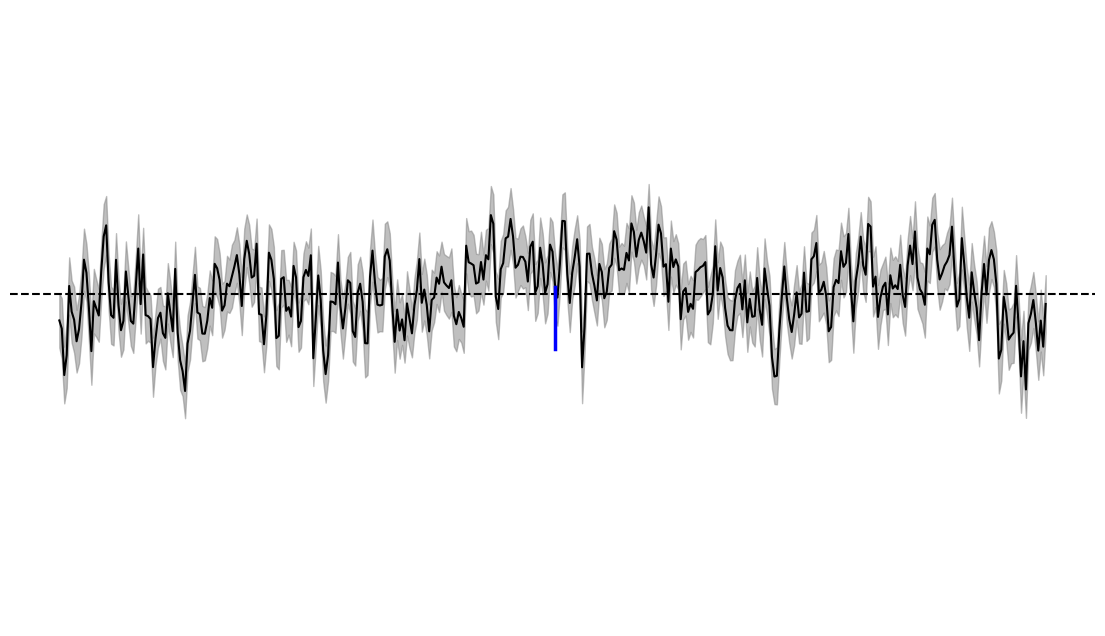

In [251]:
time = all_avg_df.index
estimate = all_avg_df # Adjust the column name as needed
se = all_se_df  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(14, 8), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound["results"], upper_bound["results"], color='grey', alpha=0.5, label="Error band")
ax.set_axis_off()
ax.axhline(y=0.5, color='black', linestyle='--')

for j, cluster in enumerate(all_results["results"]["clusters"]):
        if all_results["results"]["cluster_p_values"][j] < 0.001:
            start, end = time[cluster[0][0]], time[cluster[0][-1]]
            ax.axvspan(start, end, color="blue", ymin=0.0025, ymax=0.015)
ax.axvline(x=201, color='blue', ymin=0.45, ymax=0.55, linewidth=2.5)
ax.set_ylim([0.43, 0.56])

In [244]:
ax.axvline?

Signature: ax.axvline(x=0, ymin=0, ymax=1, **kwargs)
Docstring:
Add a vertical line across the Axes.

Parameters
----------
x : float, default: 0
    x position in data coordinates of the vertical line.

ymin : float, default: 0
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

ymax : float, default: 1
    Should be between 0 and 1, 0 being the bottom of the plot, 1 the
    top of the plot.

Returns
-------
`~matplotlib.lines.Line2D`

Other Parameters
----------------
**kwargs
    Valid keyword arguments are `.Line2D` properties, except for
    'transform':

    Properties:
    agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
    alpha: scalar or None
    animated: bool
    antialiased or aa: bool
    clip_box: `~matplotlib.transforms.BboxBase` or None
    clip_on: bool
    clip_path: Patch or (Path, Transform) or None
    co

<Axes: >

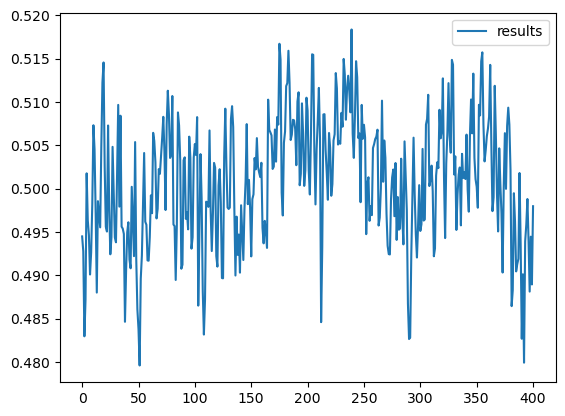

In [98]:
all_avg_df.plot()

In [99]:
path = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_2"

# Running the tests for each column

results = {}
average_df = pd.DataFrame()
se_df = pd.DataFrame()

X = extract_column_to_numpy(path, "Holmes")
print(len(X))
average_df["Holmes"] = np.mean(X, axis=0)
se_df["Holmes"] = stats.sem(X, axis=0)
X_adj = [x - 0.5 for x in X]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='mask')
results["Holmes"] = {
    "T_obs": T_obs,
    "clusters": clusters,
    "cluster_p_values": cluster_p_values,
    "H0": H0
}


24
stat_fun(H1): min=-2.299635703709432 max=3.258839493198398
Running initial clustering …
Found 0 clusters


C:\Users\ricky\AppData\Local\Temp\ipykernel_42220\1979823618.py:14: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj),


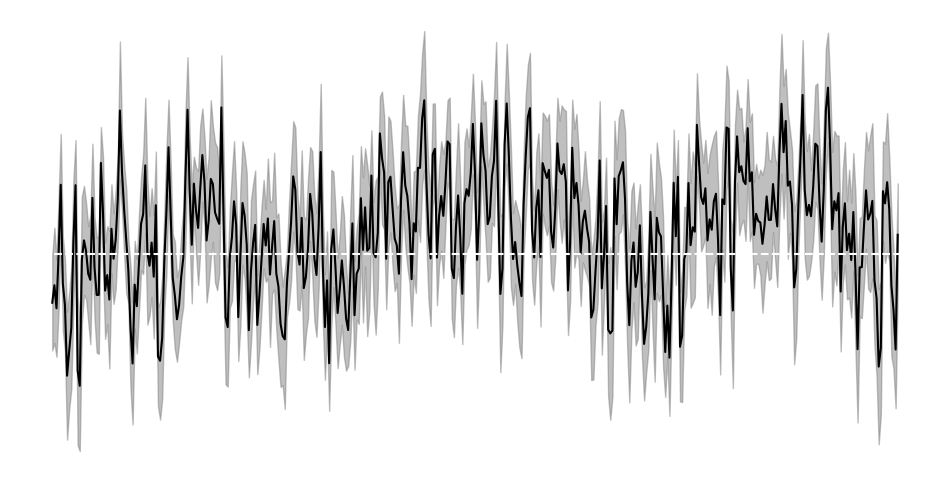

In [100]:
time = average_df.index
estimate = average_df # Adjust the column name as needed
se = se_df  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound["Holmes"], upper_bound["Holmes"], color='grey', alpha=0.5, label="Error band")
ax.set_axis_off()
ax.axhline(y=0.5, color='white', linestyle='--')

<Axes: >

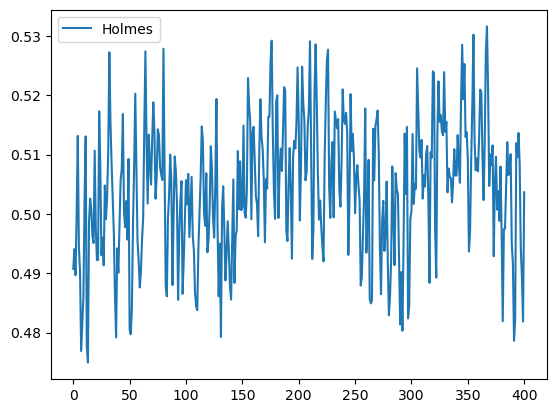

In [101]:
average_df.plot()

In [102]:
results

{'Holmes': {'T_obs': array([-1.02185208, -0.54308716, -1.12146203,  0.00490346,  1.36178199,
         -0.63674096, -1.11011351, -1.90264894, -1.66256337, -1.21343364,
          0.18423763,  1.53013594, -1.56742376, -2.02235613, -0.09304567,
          0.24987896,  0.06093348, -0.41433651, -0.40052306,  1.03773675,
         -0.26862604, -0.71108852, -0.69318492,  2.53922918,  0.72968161,
         -0.75886815, -0.43070419, -0.66119707,  0.56761369, -0.1049522 ,
          0.28871974,  1.24724445,  2.08163139,  2.09128738,  0.97850222,
          0.24915434, -0.52288915, -1.18076266, -1.7974479 , -0.69818054,
         -1.10305733, -0.19605721,  0.65159271,  0.66476551,  1.31136999,
          0.02598313, -0.23621347,  0.2101103 , -0.36744194,  0.90881178,
         -2.072675  , -1.81518704, -1.37162135, -0.15577428,  0.67592567,
          2.2471518 ,  0.8298963 , -0.54544054, -0.77243767, -1.53894268,
         -1.36945918, -0.52919755, -0.07155396,  1.16349453,  2.7455431 ,
          1.2261871

In [103]:
def extractFileByKey(folder_path, key):
    numpy_arrays = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(f'{key}.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            for column_name in df.columns:
                numpy_array = df[column_name].values
                numpy_arrays.append(numpy_array)
    
    return numpy_arrays

In [104]:
def extractFileByKeyColumn(folder_path, key, column_name):
    numpy_arrays = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(f'{key}.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)
            print(filename)
            if column_name in df.columns:
                print(column_name)
                numpy_array = df[column_name].values
                numpy_arrays.append(numpy_array)
    
    return numpy_arrays

In [219]:
path = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_2"

# Running the tests for each column
pronouns = ['I', 'YOU', 'HE', 'MY', 'HIS', 'ME', 'YOUR', 'SHE', 'HIM', 'HER']
A2_results = {}
A2avg_df = pd.DataFrame()
A2se_df = pd.DataFrame()
for pronoun in pronouns:
    X = extractFileByKey(path, pronoun)
    print(pronoun, len(X))
    A2avg_df[pronoun] = np.mean(X, axis=0)
    A2se_df[pronoun] = stats.sem(X, axis=0)
    X_adj = [x - 0.5 for x in X]
    thresh = get_threshold(0.001, len(X) - 1)
    T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='mask')
    A2_results[pronoun] = {
        "T_obs": T_obs,
        "clusters": clusters,
        "cluster_p_values": cluster_p_values,
        "H0": H0
    }


I 27
stat_fun(H1): min=-3.0548237250072594 max=2.9304944779348467
Running initial clustering …
Found 0 clusters


YOU 12
stat_fun(H1): min=-4.4150738087709565 max=4.460976355320424
Running initial clustering …
Found 3 clusters


C:\Users\ricky\AppData\Local\Temp\ipykernel_42220\1771095866.py:15: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj),


  0%|          | Permuting (exact test) : 0/2047 [00:00<?,       ?it/s]

HE 18
stat_fun(H1): min=-3.2873312606932927 max=4.281200409941641
Running initial clustering …
Found 1 cluster


  0%|          | Permuting : 0/9999 [00:00<?,       ?it/s]

MY 12
stat_fun(H1): min=-4.898203910349579 max=3.613078025763745
Running initial clustering …
Found 2 clusters


  0%|          | Permuting (exact test) : 0/2047 [00:00<?,       ?it/s]

HIS 6
stat_fun(H1): min=-6.025374134548507 max=12.352512268059542
Running initial clustering …
Found 8 clusters


  0%|          | Permuting (exact test) : 0/31 [00:00<?,       ?it/s]

ME 9
stat_fun(H1): min=-3.9937545074114316 max=5.107550999480952
Running initial clustering …
Found 1 cluster


  0%|          | Permuting (exact test) : 0/255 [00:00<?,       ?it/s]

YOUR 6
stat_fun(H1): min=-11.361136741470398 max=12.756553672036747
Running initial clustering …
Found 13 clusters


  0%|          | Permuting (exact test) : 0/31 [00:00<?,       ?it/s]

SHE 9
stat_fun(H1): min=-5.92876260727843 max=4.175299976381267
Running initial clustering …
Found 2 clusters


  0%|          | Permuting (exact test) : 0/255 [00:00<?,       ?it/s]

HIM 6
stat_fun(H1): min=-6.4071102941465155 max=11.588235294117663
Running initial clustering …
Found 7 clusters


  0%|          | Permuting (exact test) : 0/31 [00:00<?,       ?it/s]

HER 9
stat_fun(H1): min=-4.1230548212621745 max=4.742434413642388
Running initial clustering …
Found 0 clusters


C:\Users\ricky\AppData\Local\Temp\ipykernel_42220\1771095866.py:15: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj),


In [226]:
A2_results["HE"]["cluster_p_values"]

array([0.0079])

(0.43, 0.56)

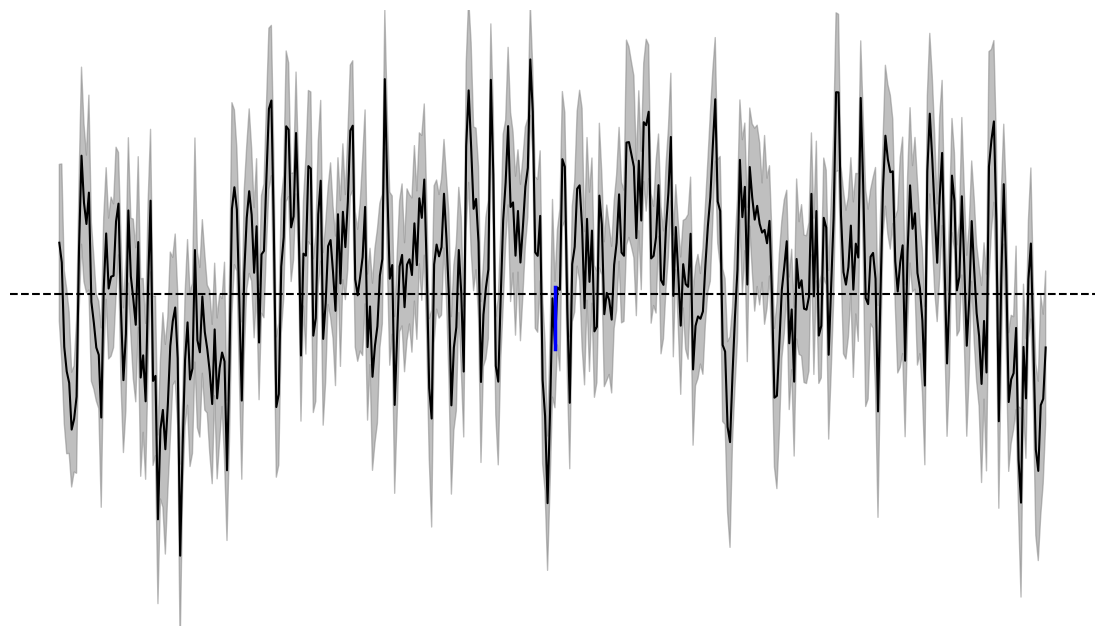

In [252]:
time = A2avg_df.index
estimate = A2avg_df["HE"] # Adjust the column name as needed
se = A2se_df["HE"]  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(14, 8), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound, upper_bound, color='grey', alpha=0.5, label="Error band")
ax.set_axis_off()
ax.axhline(y=0.5, color='black', linestyle='--')
ax.axvline(x=201, color='blue', ymin=0.45, ymax=0.55, linewidth=2.5)
ax.set_ylim([0.43, 0.56])


<Axes: >

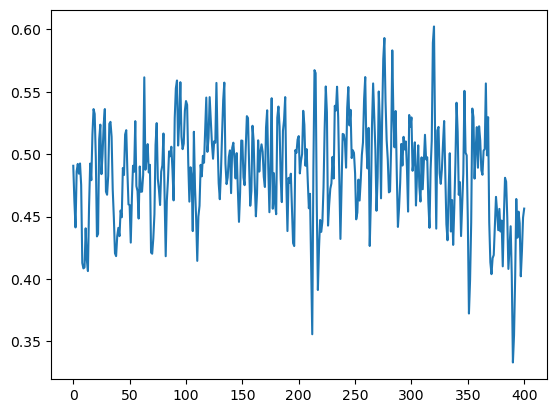

In [107]:
A2avg_df["YOUR"].plot()

<Axes: >

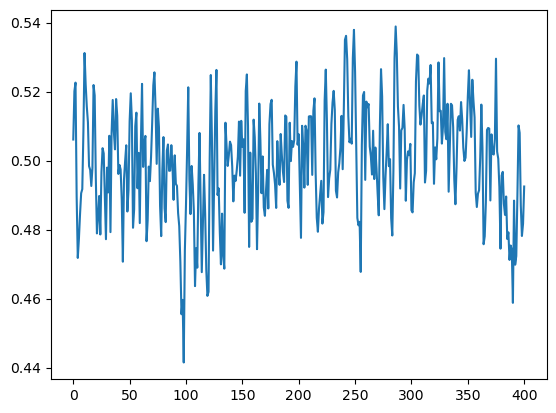

In [108]:
A2avg_df["MY"].plot()

In [109]:
all_results = {}
all_avg_df = pd.DataFrame()
se_df = pd.DataFrame()

X = extractFileByKeyColumn(path, "HE", "Holmes")
print(len(X))
all_avg_df["results"] = np.mean(X, axis=0)
se_df["results"] = stats.sem(X, axis=0)
X_adj = [x - 0.5 for x in X]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='mask')
all_results["results"] = {
    "T_obs": T_obs,
    "clusters": clusters,
    "cluster_p_values": cluster_p_values,
    "H0": H0
}

df_scores_pt_01_trial_HE.csv
Holmes
df_scores_pt_01_trial_SHE.csv
df_scores_pt_02_trial_HE.csv
Holmes
df_scores_pt_02_trial_SHE.csv
df_scores_pt_03_trial_HE.csv
Holmes
df_scores_pt_03_trial_SHE.csv
3
stat_fun(H1): min=-12.09258508177067 max=19.141494175553024
Running initial clustering …
Found 2 clusters


  0%|          | Permuting (exact test) : 0/3 [00:00<?,       ?it/s]

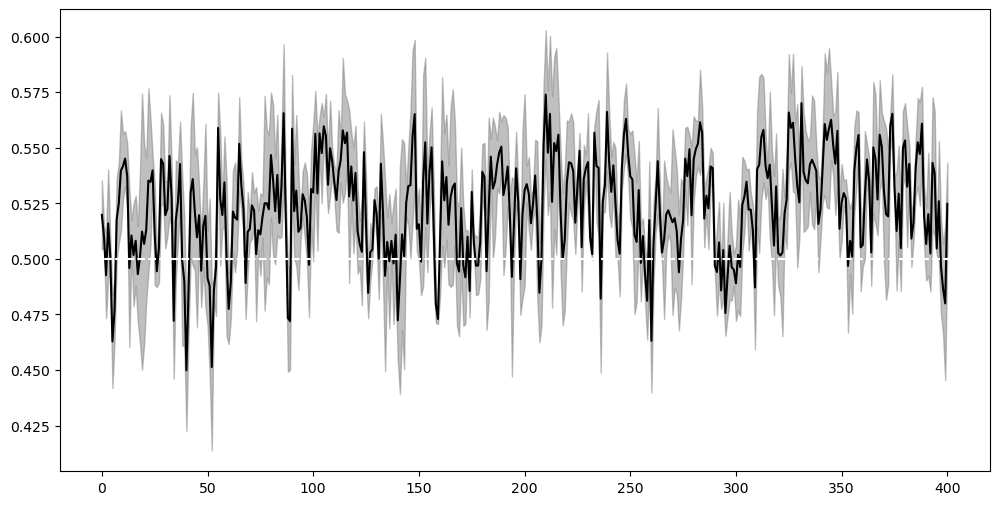

In [110]:
time = average_df.index
estimate = all_avg_df # Adjust the column name as needed
se = se_df  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound["results"], upper_bound["results"], color='grey', alpha=0.5, label="Error band")
# ax.set_axis_off()
ax.axhline(y=0.5, color='white', linestyle='--')

Analysis 3

In [263]:
path = r"C:\Users\ricky\OneDrive\Desktop\Datasci125\Code\Results\Analysis_3"

# Running the tests for each column

all_results = {}
all_avg_df = pd.DataFrame()
all_se_df = pd.DataFrame()

X = extract_to_numpy(path)
print(len(X))
all_avg_df["results"] = np.mean(X, axis=0)
all_se_df["results"] = stats.sem(X, axis=0)
thresh = get_threshold(0.001, len(X) - 1)
X_adj = [x - 0.5 for x in X]
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj), 
                                                                     n_permutations=10000,
                                                                     threshold=get_threshold(0.001, len(X_adj)),
                                                                     tail=0,
                                                                     n_jobs=-1,
                                                                     out_type='mask')
all_results["results"] = {
    "T_obs": T_obs,
    "clusters": clusters,
    "cluster_p_values": cluster_p_values,
    "H0": H0
}

39
stat_fun(H1): min=-3.475714846291171 max=2.450273611855057
Running initial clustering …
Found 0 clusters


C:\Users\ricky\AppData\Local\Temp\ipykernel_42220\481458531.py:15: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(np.array(X_adj),


In [264]:
all_results

{'results': {'T_obs': array([-0.50327036, -1.37062512, -1.45682939, -1.48295805, -3.00557812,
         -1.94403391, -0.91480063,  0.2318045 , -0.567873  , -1.30579965,
         -1.79089512, -1.66620244, -0.149164  , -1.13795093, -2.75482274,
         -1.91793489, -2.2313213 , -2.03241023, -1.71557863, -2.78427371,
         -2.25510717, -1.05178714, -0.70652909,  0.33795061, -0.79048892,
         -1.37235506, -2.12412524, -0.52103119,  0.06422302, -0.62820475,
         -1.02257066, -0.74829017,  0.3935271 ,  1.81161636,  1.60136038,
          0.72781136, -0.87651522,  0.18806664,  0.83781908,  0.31274555,
          0.63505452, -0.59879535,  0.22132242,  1.84134022,  1.88146184,
          2.45027361,  1.02708774,  0.39312798, -0.36132661, -0.4118729 ,
         -0.51910649,  1.33717827,  0.09351909, -0.77386372,  0.31608972,
          1.16029978, -0.5407159 , -1.34794894, -2.06179364, -2.29839847,
         -2.14887729, -2.47751598, -1.2858124 , -0.77424049,  0.27525282,
          0.492178

<Axes: >

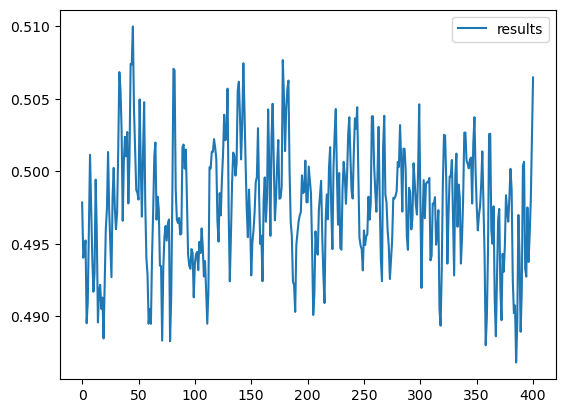

In [113]:
all_avg_df.plot()

(0.45, 0.55)

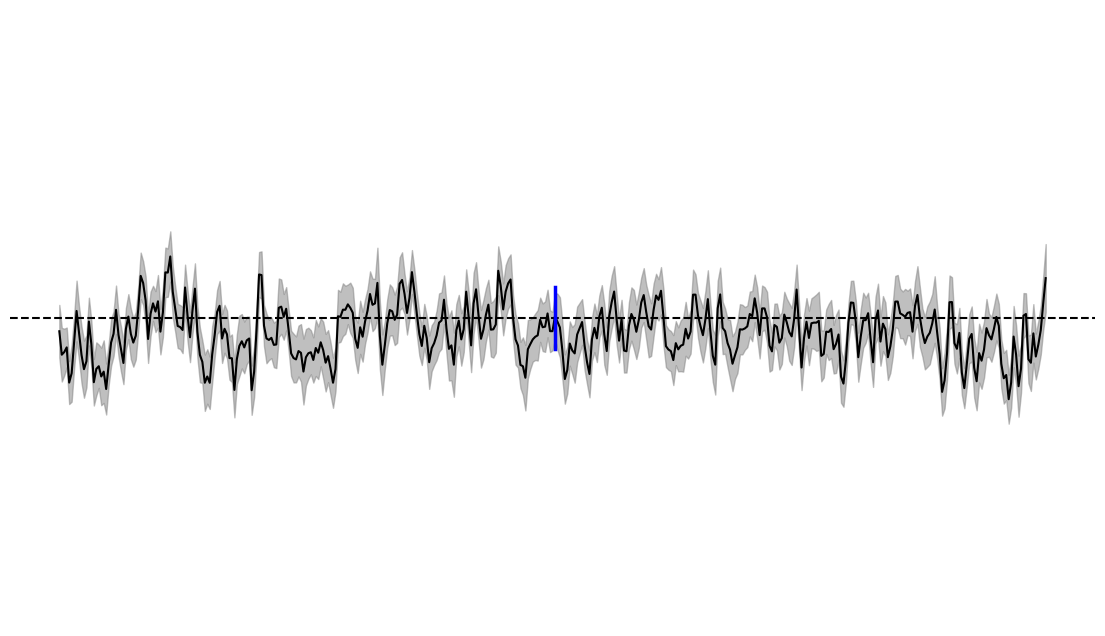

In [270]:
time = average_df.index
estimate = all_avg_df # Adjust the column name as needed
se = all_se_df  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(14, 8), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound["results"], upper_bound["results"], color='grey', alpha=0.5, label="Error band")
ax.set_axis_off()
ax.axhline(y=0.5, color='black', linestyle='--')
ax.axvline(x=201, color='blue', ymin=0.45, ymax=0.55, linewidth=2.5)
ax.set_ylim([0.45, 0.55])

In [115]:
from scipy.io import wavfile

# Path to your .wav file
wav_file_path = r'C:\Users\ricky\OneDrive\Desktop\Datasci125\Data\stimuli\01_1.wav'

sample_rate, data = wavfile.read(wav_file_path)

# Calculate the number of samples to skip (80 ms)
start_sample = int((1000 / 1000) * sample_rate)

# Calculate the number of samples to plot (920 ms)
end_sample = int((3000 / 1000) * sample_rate)

# Extract the data from 80 ms to 1000 ms
extracted_data = data[start_sample:end_sample]

# Create a time array for the x-axis (from 80 ms to 1000 ms)
time_array = np.linspace(1000 / 1000, 3000 / 1000, end_sample - start_sample, endpoint=False)

C:\Users\ricky\AppData\Local\Temp\ipykernel_42220\2060965887.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(wav_file_path)


(0.9000022675736962, 3.099952380952381, -7645.8, 14437.8)

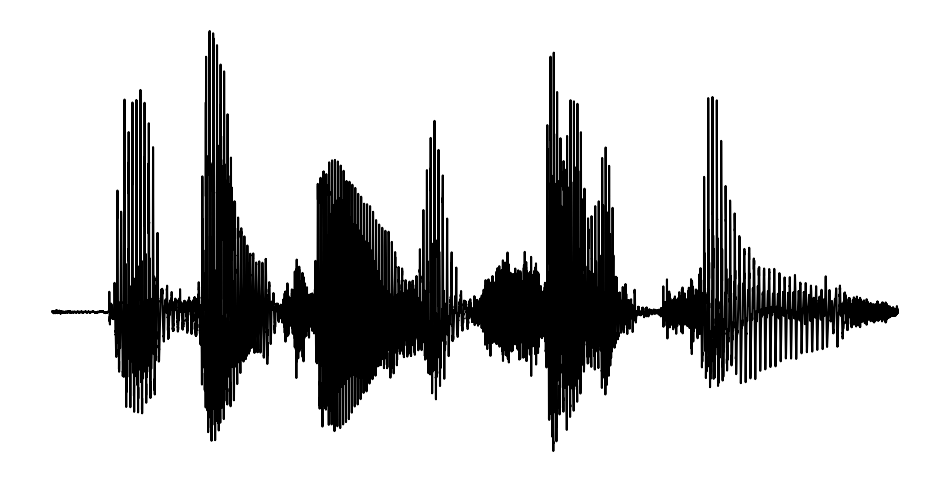

In [116]:
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
ax.set_facecolor('none')


plt.plot(time_array, extracted_data, color='black')
plt.axis('off')

In [117]:
picks = raw.ch_names[:5]
raw.plot(order=np.arange(len(picks)), n_channels=len(picks), picks=picks, show=True)

NameError: name 'raw' is not defined

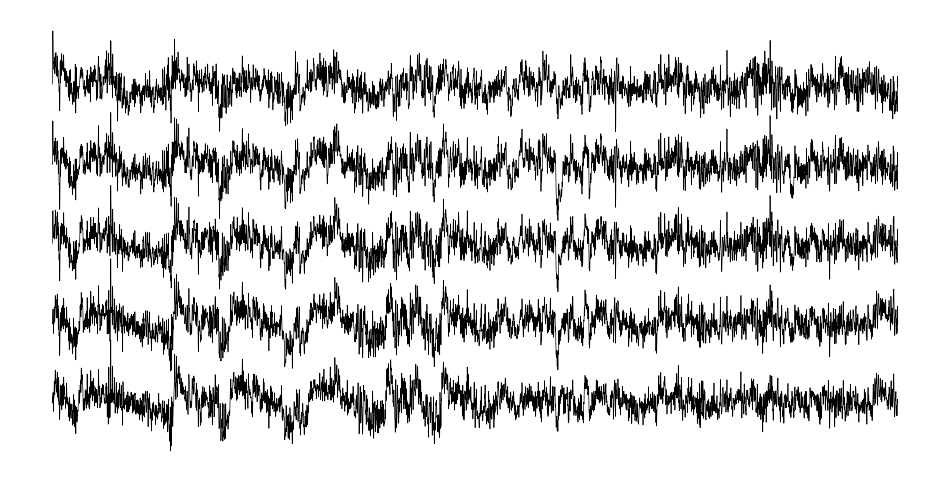

In [ ]:
picks = raw.ch_names[:5]

# Extract the data for the first 5 channels
data, times = raw[picks, :]

plt.figure(figsize=(12, 6), facecolor='none')

ax = plt.gca()
ax.set_facecolor('none')

for i, channel_data in enumerate(data):
    plt.plot(times, channel_data + i * 1e-12, label=f'Channel {i+1}', color="black", linewidth=0.5)  # Offset for better visualization

plt.axis('off')
plt.show()

In [ ]:
time = average_df.index
estimate = average_df["NOUN"]  # Adjust the column name as needed
se = se_df["NOUN"]  # Adjust the column name as needed

# Calculate the upper and lower bounds for the error bands
upper_bound = estimate + se
lower_bound = estimate - se

# Plot the parameter estimate with shaded error bands
fig, ax = plt.subplots(figsize=(12, 6), facecolor='none')
ax.set_facecolor('none')
ax.plot(time, estimate, color="black", label="Estimate")
ax.fill_between(time, lower_bound, upper_bound, color='gray', alpha=0.5, label="Error band")

In [206]:
POS = [("PRON", "green"), ("PROPN", "blue"), ("NOUN", "red")]
POS = [("PROPN", "blue"), ("PRON", "green")]

In [205]:
average_df

,PRON,PROPN
0,0.497785,0.501247
1,0.506143,0.503468
2,0.513879,0.502080
3,0.508214,0.506521
4,0.497507,0.505665
...,...,...
396,0.518898,0.528535
397,0.508614,0.512326
398,0.504460,0.502683
399,0.497300,0.501939


KeyError: 'PROPN'

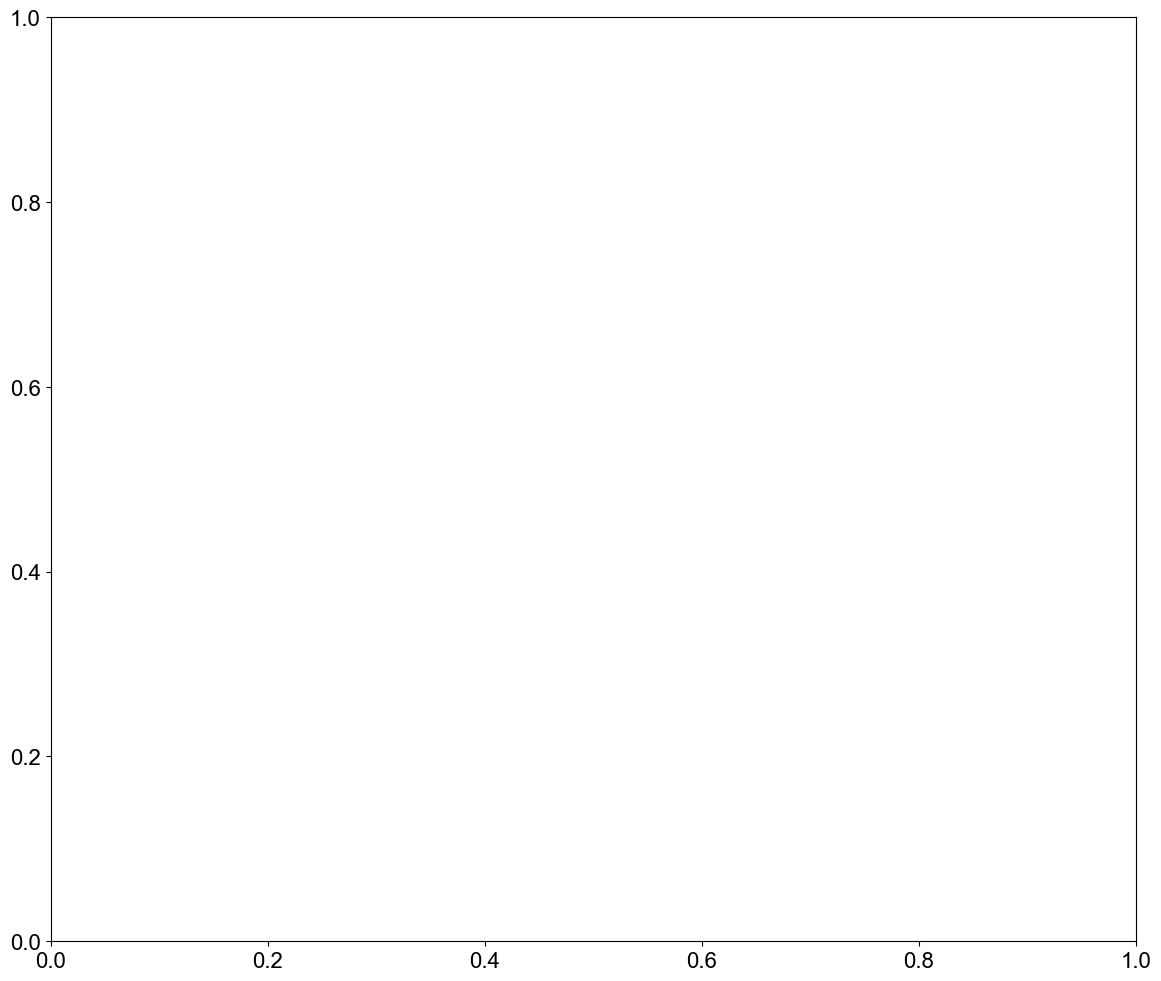

In [210]:
time = average_df.index

# Create a single plot
fig, ax = plt.subplots(figsize=(14, 12), facecolor='white')
ax.set_facecolor('white')

# Plot each parameter estimate with shaded error bands
s = 0
for i, pos_tup in enumerate(POS):
    pos, color = pos_tup
    estimate = average_df[pos]
    se = se_df[pos]

    upper_bound = estimate + se
    lower_bound = estimate - se

    # Plot the parameter estimate
    ax.plot(time, estimate, color=color, label=pos)
    ax.fill_between(time, lower_bound, upper_bound, color=color, alpha=0.25)

    
    for j, cluster in enumerate(results[pos]["clusters"]):
        if results[pos]["cluster_p_values"][j] < 0.001:
            s += 1
            start, end = time[cluster[0][0]], time[cluster[0][-1]]
            ax.axvspan(start, end, color=color, ymin=0.0025 + (0.025 * s), ymax=0.015 + (0.025 * s))

# Add horizontal and vertical reference lines
ax.axhline(y=0.5, color='black', linestyle='--')
ax.axvline(x=200, color='black', ymax=0.15)
ax.set_ylim([0.48, 0.65])
ax.axis('off')



In [193]:
ax.set_ylim?

Signature:
ax.set_ylim(
    bottom=None,
    top=None,
    *,
    emit=True,
    auto=False,
    ymin=None,
    ymax=None,
)
Docstring:
Set the y-axis view limits.

Parameters
----------
bottom : float, optional
    The bottom ylim in data coordinates. Passing *None* leaves the
    limit unchanged.

    The bottom and top ylims may also be passed as the tuple
    (*bottom*, *top*) as the first positional argument (or as
    the *bottom* keyword argument).

    .. ACCEPTS: (bottom: float, top: float)

top : float, optional
    The top ylim in data coordinates. Passing *None* leaves the
    limit unchanged.

emit : bool, default: True
    Whether to notify observers of limit change.

auto : bool or None, default: False
    Whether to turn on autoscaling of the y-axis. *True* turns on,
    *False* turns off, *None* leaves unchanged.

ymin, ymax : float, optional
    They are equivalent to bottom and top respectively, and it is an
    error to pass both *ymin* and *bottom* or *ymax* and *t

In [ ]:
metadata

,onset,duration,sample,type,value,POS,syllables,coref
3,38.863643,0.129705,4.663737e+04,word_onset_01,THE,DET,1,None
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES,NOUN,4,None
15,39.671807,0.089796,4.760717e+04,word_onset_01,OF,ADP,1,None
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK,PROPN,2,None
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES,PROPN,2,Holmes
...,...,...,...,...,...,...,...,...
39119,3752.574923,0.399093,4.503091e+06,word_onset_06,AWAY,ADV,2,None
39123,3752.974016,0.269388,4.503570e+06,word_onset_06,THESE,DET,1,None
39127,3753.243404,0.478912,4.503893e+06,word_onset_06,BLEAK,ADJ,1,None
39132,3753.722316,0.628571,4.504468e+06,word_onset_06,AUTUMNAL,ADJ,3,None


In [ ]:
noun_df = metadata[metadata["POS"].isin(["PRON", "PROPN", "NOUN"])]

In [ ]:
noun_df

,onset,duration,sample,type,value,POS,syllables,coref
6,38.993349,0.678458,4.679302e+04,word_onset_01,ADVENTURES,NOUN,4,None
18,39.761603,0.488889,4.771492e+04,word_onset_01,SHERLOCK,PROPN,2,None
24,40.250491,0.698413,4.830159e+04,word_onset_01,HOLMES,PROPN,2,Holmes
33,41.836886,0.698413,5.020526e+04,word_onset_01,SCANDAL,PROPN,2,None
46,42.944369,0.558730,5.153424e+04,word_onset_01,BOHEMIA,PROPN,3,None
...,...,...,...,...,...,...,...,...
39053,3747.436601,0.179592,4.496925e+06,word_onset_06,MY,PRON,1,Holmes
39056,3747.616193,0.518821,4.497140e+06,word_onset_06,VIOLIN,NOUN,2,None
39076,3749.551794,0.439002,4.499463e+06,word_onset_06,PROBLEM,NOUN,2,None
39084,3749.990796,0.099773,4.499990e+06,word_onset_06,WE,PRON,1,Frank


In [255]:
characters = ['Holmes', 'Watson', 'McCarthy', 'Clair', 'Doran']
upper_char = [char.upper() for char in characters]

In [254]:
import pandas as pd

# Assuming noun_df, upper_char, and characters are already defined

# Calculate value_counts and coref_counts
value_counts = noun_df[noun_df['value'].isin(upper_char)]['value'].value_counts()
coref_counts = noun_df[noun_df['coref'].isin(characters)]['coref'].value_counts()

# Convert the Series to DataFrames
value_counts_df = value_counts.reset_index()
coref_counts_df = coref_counts.reset_index()

# Rename the columns
value_counts_df.columns = ['void', 'value_counts']
coref_counts_df.columns = ['character', 'coref_counts']

final_df = value_counts_df.merge(coref_counts_df, left_index=True, right_index=True)
final_df = final_df[["value_counts", "coref_counts", "character"]]



NameError: name 'noun_df' is not defined

In [256]:
data = {
    "value_counts": [377, 72, 33, 23, 10],
    "coref_counts": [2706, 1366, 361, 328, 260],
    "character": ["Holmes", "Watson", "McCarthy", "Clair", "Doran"]
}

final_df = pd.DataFrame(data)

In [257]:
final_df

,value_counts,coref_counts,character
0,377,2706,Holmes
1,72,1366,Watson
2,33,361,McCarthy
3,23,328,Clair
4,10,260,Doran


In [ ]:
final_df

,value_counts,coref_counts,character
0,377,2706,Holmes
1,72,1366,Watson
2,33,361,McCarthy
3,23,328,Clair
4,10,260,Doran


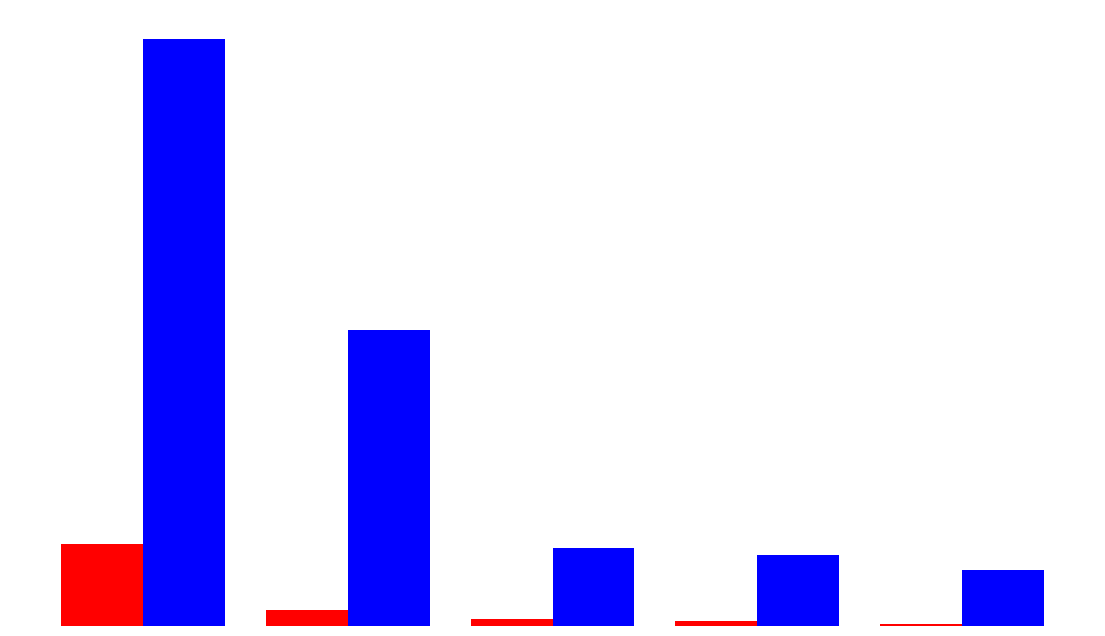

In [262]:
fig, ax = plt.subplots(figsize=(14, 8), facecolor='none')
ax.axis("off")


final_df.plot(
    kind='bar', 
    x='character', 
    color=['red', "blue"], 
    width=0.8,
    ax=ax)

ax.legend().set_visible(False)  
